In [1]:


import numpy as np
import math
import sounddevice
# import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
from Audio_data import Audio_data
from Matrix_array import Matrix_array
from Audio_source import Audio_source
from Color_map import Color_map
import config

# GLOBAL VARIABLES
c = 340                     # propagation speed of sound

In [2]:
def antenna_setup():
    r_a1 = config.r_a1      # coordinate position of origin of array1
    r_a2 = config.r_a2      # coordinate position of origin of array2
    r_a3 = config.r_a3      # coordinate position of origin of array3
    r_a4 = config.r_a4      # coordinate position of origin of array4
    uni_distance = config.distance
    row_elements = config.rows
    column_elements = config.columns

    # array_matrix_1, array_matrix_2, array_matrix_3, array_matrix_4 below can be generated in parallell
    array_matrix_1 = Matrix_array(
        r_a1, uni_distance, row_elements, column_elements)
    array_matrix_2 = Matrix_array(
        r_a2, uni_distance, row_elements, column_elements)
    array_matrix_3 = Matrix_array(
        r_a3, uni_distance, row_elements, column_elements)
    array_matrix_4 = Matrix_array(
        r_a4, uni_distance, row_elements, column_elements)

    # array_matrices contains the current active arrays that should be used (currently only array1 and array2)
    array_matrices = np.array([array_matrix_1], dtype=object)

    sub_arrays = len(array_matrices)

    for array in range(sub_arrays):
        plt.title('Array setup')
        plt.scatter(array_matrices[array].get_r_prime()[
                    0, :], array_matrices[array].get_r_prime()[1, :])

    return array_matrices


In [3]:


def generate_array_signals(matrix_array, sources, t):
    r_prime = matrix_array.get_r_prime()
    Audio_signal = np.zeros((len(t), len(r_prime[0, :])))

    for sample in range(len(t)):
        # print stuff so user know how many samples that have been generated
        if (sample+1 in np.linspace(0, len(t), 11)) or (sample == 0):
            # print stuff so user know how many samples that have been generated
            print(sample+1)
        for mic in range(len(r_prime[0, :])):
            x_i = r_prime[0, mic]
            y_i = r_prime[1, mic]
            temp_signal_sample = 0
            for source in range(len(sources)):
                if (sources[source].get_t_start() < t[sample]) and (t[sample] < sources[source].get_t_end()):
                    frequencies_ps = sources[source].get_frequency()
                    theta_source = sources[source].get_theta()
                    phi_source = sources[source].get_phi()
                    rho_soruce = sources[source].get_rho()
                    for freq_ind in range(len(frequencies_ps)):
                        k = 2*math.pi*frequencies_ps[freq_ind]/c
                        r_1 = np.array([x_i, y_i, 0])
                        r_2 = rho_soruce * r_vec(theta_source, phi_source)
                        norm_coeff = np.linalg.norm(r_2-r_1)
                        phase_offset = -k*norm_coeff
                        element_amplitude = 1/norm_coeff
                        temp_signal_sample += element_amplitude * \
                            math.sin(
                                2*math.pi * frequencies_ps[freq_ind] * t[sample] + phase_offset)
            Audio_signal[sample, mic] = temp_signal_sample
    return Audio_signal


In [4]:


def r_vec(theta, phi):
    r = np.array([(math.sin(theta)*math.cos(phi)),
                 math.sin(theta)*math.sin(phi), math.cos(theta)])
    return r


In [5]:
def load_calibration_weights(array, elements, f_bands):
    # placeholder function, to be completed later
    # function should load calibration weights form file
    # returns matrix with calibration weightsfor all microphones, at all calibration frequencies
    weights = np.ones((f_bands, elements))
    return weights


In [6]:
def old_listening_improved(array_audio_signals, array_matrices, theta, phi, adaptive_weight_matrix, calibration_weights, filter_coefficients, frequency_bands, f_sampling, samples, sub_arrays):
    x_factor = math.sin(theta) * math.cos(phi)
    y_factor = math.sin(theta) * math.sin(phi)
    audio_out = np.zeros((samples, 1))

    for array in range(sub_arrays):
        #print('array: '+str(array+1))               # print for user
        r_prime = array_matrices[array].get_r_prime()
        audio_signals = array_audio_signals[array].get_audio_signals()

        elements = config.rows*config.columns
        print('freq_ind: ', end=' ')
        for freq_ind in range(len(filter_coefficients[:, 0])):
            print(str(freq_ind+1), end=' ')  # print for user
            # filter coefficient for the current band
            b = filter_coefficients[freq_ind, :]
            frequency = frequency_bands[freq_ind]   # center frequency
            k = 2*math.pi*frequency/c               # the narrowband frequency
            ny = frequency/f_sampling               # normalized frequency
            weights = adaptive_weight_matrix[weight_index(frequency)-1, :]

            audio_temp = np.zeros((samples, 1))
            mic_data = np.zeros((samples, 1))
            #print('\t mic_ind:', end=' ')           # print stuff for user
            for mic_ind in range(elements):
                #print(str(mic_ind+1), end=' ')      # print stuff for user
                if weights[mic_ind] == 1:
                    audio_temp[:, 0] = calibration_weights[freq_ind, mic_ind] * \
                        signal.lfilter(b, 1.0, audio_signals[:, mic_ind])
                    phase_shift_value = -k * \
                        (r_prime[0, mic_ind] * x_factor +
                         r_prime[1, mic_ind]*y_factor)

                    #   Sum the individually shifted data from the atnenna elements as well as weight them with
                    #   appropriate weight.
                    mic_data += weights[mic_ind] * \
                        phase_shift(audio_temp, ny, phase_shift_value)

            norm_coeff = 1/sum(weights)
            audio_out += mic_data * norm_coeff
    return audio_out


In [34]:
import multiprocessing
manager = multiprocessing.Manager()
return_queue = manager.dict()

backend_type = multiprocessing.Process


def kernel(freq_ind, elements, audio_signals, r_prime, x_factor, y_factor, array_matrices, theta, phi, adaptive_weight_matrix, calibration_weights, filter_coefficients, frequency_bands, f_sampling, samples, sub_arrays, return_queue=None):
    # print(freq_ind, elements, audio_signals, r_prime, x_factor, y_factor, array_matrices, theta, phi,
    #       adaptive_weight_matrix, calibration_weights, filter_coefficients, frequency_bands, f_sampling, samples, sub_arrays)
    # return
    try:
        b = filter_coefficients[freq_ind, :]
        frequency = frequency_bands[freq_ind]   # center frequency
        k = 2*math.pi*frequency/c               # the narrowband frequency
        ny = frequency/f_sampling               # normalized frequency
        weights = adaptive_weight_matrix[weight_index(frequency)-1, :]

        audio_temp = np.empty((samples, 1)) # Changed to empty from zeros
        mic_data = np.zeros((samples, 1))
        #print('\t mic_ind:', end=' ')           # print stuff for user
        # internal_return_queue = manager.dict()
        # def internal_kernel(mic_ind, internal_return_queue=None):
        #     if weights[mic_ind] == 1:
        #         audio_temp[:, 0] = calibration_weights[freq_ind, mic_ind] * \
        #             signal.lfilter(b, 1.0, audio_signals[:, mic_ind])
        #         phase_shift_value = -k * \
        #             (r_prime[0, mic_ind] * x_factor +
        #                 r_prime[1, mic_ind]*y_factor)

        #         internal_return_queue[mic_ind] = weights[mic_ind] * \
        #             phase_shift(audio_temp, ny, phase_shift_value)
        
        for mic_ind in range(elements):
            #print(str(mic_ind+1), end=' ')      # print stuff for user
            if weights[mic_ind] == 1:
                audio_temp[:, 0] = calibration_weights[freq_ind, mic_ind] * \
                    signal.lfilter(b, 1.0, audio_signals[:, mic_ind])
                phase_shift_value = -k * \
                    (r_prime[0, mic_ind] * x_factor +
                        r_prime[1, mic_ind]*y_factor)

                #   Sum the individually shifted data from the atnenna elements as well as weight them with
                #   appropriate weight.
                mic_data += weights[mic_ind] * \
                    phase_shift(audio_temp, ny, phase_shift_value)

    

        norm_coeff = 1/sum(weights)
        return_queue[freq_ind] = mic_data * norm_coeff
        print(f"Process: {freq_ind} done!")
    except Exception as e:
        print(e)
        return_queue[freq_ind] = None
        print(f"Process: {freq_ind} Error!")


def old_kernel(freq_ind, mic_ind, elements, audio_signals, r_prime, x_factor, y_factor, array_matrices, theta, phi, adaptive_weight_matrix, calibration_weights, filter_coefficients, frequency_bands, f_sampling, samples, sub_arrays, return_queue=None):
    
    frequency = frequency_bands[freq_ind]   # center frequency
    
    weights = adaptive_weight_matrix[weight_index(frequency)-1, :]
    if weights[mic_ind] != 1:
        return

    b = filter_coefficients[freq_ind, :]
    k = 2*math.pi*frequency/c               # the narrowband frequency
    ny = frequency/f_sampling               # normalized frequency

    audio_temp = np.empty((samples, 1))  # Changed to empty from zeros
    mic_data = np.zeros((samples, 1))

    
    audio_temp[:, 0] = calibration_weights[freq_ind, mic_ind] * \
        signal.lfilter(b, 1.0, audio_signals[:, mic_ind])
    phase_shift_value = -k * \
        (r_prime[0, mic_ind] * x_factor +
            r_prime[1, mic_ind]*y_factor)

    #   Sum the individually shifted data from the atnenna elements as well as weight them with
    #   appropriate weight.
    mic_data += weights[mic_ind] * \
        phase_shift(audio_temp, ny, phase_shift_value)

def listening_improved(array_audio_signals, array_matrices, theta, phi, adaptive_weight_matrix, calibration_weights, filter_coefficients, frequency_bands, f_sampling, samples, sub_arrays):
    x_factor = math.sin(theta) * math.cos(phi)
    y_factor = math.sin(theta) * math.sin(phi)
    audio_out = np.zeros((samples, 1))

    for array in range(sub_arrays):
        r_prime = array_matrices[array].get_r_prime()
        audio_signals = array_audio_signals[array].get_audio_signals()

        elements = config.rows*config.columns
        myjobs_old = [freq_ind for freq_ind in range(len(filter_coefficients[:, 0]))]
        #myjobs = [0, 1]
        myjobs = []
        for k in range(len(myjobs_old)):
            for i in range(elements):
                myjobs.append((k,i))
        myjobs = [0 for _ in range(len(myjobs_old))]

        # print(jobs)
        # freq_ind = jobs[0]
        # b = filter_coefficients[freq_ind, :]
        # print(b)

        # return
        import threading
        
        #backend_type = threading.Thread

        jobs = []
        for freq_ind in myjobs:
            p = backend_type(
                target=kernel, args=(freq_ind, elements, audio_signals, r_prime, x_factor, y_factor, array_matrices, theta, phi, adaptive_weight_matrix, calibration_weights, filter_coefficients, frequency_bands, f_sampling, samples, sub_arrays), kwargs=dict(return_queue=return_queue))
            jobs.append(p)
        
        for p in jobs:
            p.start()

        for proc in jobs:
            proc.join()

    # return color_maps_complete
    return return_queue


In [8]:


def adaptive_array_config_matrix(matrix_array):
    # Creates the weight matrix
    row_elements = matrix_array.get_row_elements()
    column_elements = matrix_array.get_row_elements()

    weight_matrix = np.zeros((7, row_elements*column_elements))

    for mode in range(1, config.modes+1):
        weight = np.zeros((1, row_elements*column_elements))
        row_lim = math.ceil(row_elements/mode)
        column_lim = math.ceil(column_elements/mode)
        for i in range(row_lim):
            for j in range(column_lim):
                # this calculation could be wrong thanks to matlab and python index :))
                element_index = (mode*i*row_elements + mode*j)
                weight[0, element_index] = 1
        weight_matrix[mode-1, :] = weight
    return weight_matrix


In [9]:
def weight_index(frequency):
    # calculates what mode to use, depending on the wavelength of the signal
    uni_distance = config.distance              # distance between elements
    # relative wavelength to distance between microphone elements
    wavelength_rel = frequency*uni_distance/c

    if wavelength_rel > 0.1581:
        mode = 1
    elif (wavelength_rel <= 0.156) and (wavelength_rel > 0.0986):
        mode = 3
    elif (wavelength_rel <= 0.0986) and (wavelength_rel > 0.085):
        mode = 5
    elif (wavelength_rel <= 0.085) and (wavelength_rel > 0.07):
        mode = 6
    else:
        mode = 7
    return mode


In [10]:


def phase_shift(x, ny, phase):
    #   Input signal x
    #
    #   Output signal y
    #
    #   if x = cos(n*2*pi*ny), then y = cos(n*2*pi*ny + phase)
    #
    x_length = len(x)
    y = np.zeros((x_length, 1))

    for i in range(x_length-1):
        y[i] = math.cos(phase) * x[i] + math.sin(phase) / \
            (2*math.pi*ny)*(x[i+1]/2 - x[i-1]/2)

    return y


In [11]:
def calculate_filter_coefficients(f_sampling, frequency_bands):
    scale_factor = config.scale_factor
    f_bands_N = config.f_bands_N
    filter_order = config.filter_order
    f_coefficients = np.zeros((f_bands_N, filter_order))
    for freq_ind in range(config.f_bands_N):
        nu_0 = 2*frequency_bands[freq_ind]/f_sampling
        cut_off = [nu_0 - nu_0/scale_factor, nu_0 + nu_0/scale_factor]
        b = signal.firwin(filter_order, cut_off, window="hamming",
                          pass_zero=False)  # filter coefficients
        f_coefficients[freq_ind, :] = b
    return f_coefficients


In [12]:
#from pathlib import Path


def load_data(filename):
    initial = config.initial_values
    # Load recorded data from file
    path = Path('/home/batman/BatSignal/data/studion1507/' + filename + '.txt')
    data = np.loadtxt(open(path, 'rb'), delimiter=',')

    # Get sampling frequency
    f_sampling = data[0, 0]

    # take out only the values of the microphones (column 2:66)
    # and data after the initial startup (rows initial:end)
    data = data[initial:, 2:66]
    return Audio_data(data), int(f_sampling)


In [13]:


def play_sound(sound_signal, f_sampling):
    # plays sound, and writes audio to .wav file
    scaled_signal = sound_signal/np.max(np.abs(sound_signal))  # Scaled signal
    sounddevice.play(scaled_signal, f_sampling, blocking=True)

    sf.write("test.wav", scaled_signal, int(f_sampling), 'PCM_24')


In [14]:
# Initialization
# f_sampling, t_start, t_end, away_distance are user defined variables
f_sampling = 16000# config.f_sampling                      # sampling frequency in Hz
t_start = config.t_start                            # start time of simulation
t_end = config.t_end                                # end time of simulation
t_total = t_end - t_start                           # total simulation time
t = np.linspace(t_start, t_end, t_total*f_sampling)  # time vector

# distance between the array and sources
away_distance = config.away_distance


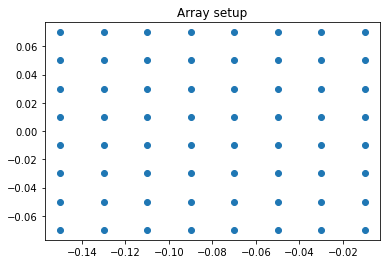

In [15]:


# set up arrays
array_matrices = antenna_setup()
sub_arrays = len(array_matrices)


In [16]:


# Create and place out sources
source1 = Audio_source(config.f_start1, config.f_end1, config.f_res1,
                       config.theta_deg1, config.phi_deg1, config.away_distance, config.t_start1, config.t_end1)
source2 = Audio_source(config.f_start2, config.f_end2, config.f_res2,
                       config.theta_deg2, config.phi_deg2, config.away_distance, config.t_start2, config.t_end2)
sources = np.array([source1, source2])


In [17]:
# AUDIO SIGNALS
if True:
    filename = "array_audio_signals.npy"
    try:
        # array_audio_signals = np.load(filename)
        array_audio_signals = np.load(filename, allow_pickle=True)
        print("Loading from Memory: " + filename)
    except:
        print("Creating data")

        # Create and place out sources
        # source1 and source2 below can be generated in parallell
        source1 = Audio_source(config.f_start1, config.f_end1, config.f_res1,
                               config.theta_deg1, config.phi_deg1, config.away_distance, config.t_start1, config.t_end1)
        source2 = Audio_source(config.f_start2, config.f_end2, config.f_res2,
                               config.theta_deg2, config.phi_deg2, config.away_distance, config.t_start2, config.t_end2)
        sources = np.array([source1])

        # GENERATE AUDIO SIGNAL
        # will only be used to emulate data, this will not be used when the algoritm runs with real data
        array_audio_signals = np.zeros((sub_arrays), dtype=object)
        print('Number of samples generated (of '+str(f_sampling*t_total)+'):')
        for array in range(sub_arrays):  # PARALLELL
            # generate the audio signals on each array-element for each sub-array
            temp_signal = generate_array_signals(
                array_matrices[array], sources, t)
            array_audio_signals[array] = Audio_data(temp_signal)
            print('Audio signal for array '+str(array+1)+' generated')

        np.save(filename, array_audio_signals)

# elif config.audio_signals == 'recorded':
#     filename = 'studion_A2_sound_0deg.bin'
#     print('Loading recorded data: '+filename)
#     array_audio_signals = np.zeros((sub_arrays), dtype=object)
#     array_audio_signals[0], f_sampling = load_data(filename)
# else:
#     array_audio_signals = 0


Loading from Memory: array_audio_signals.npy


In [18]:
# Play recorded sound from original signal from one mic (mic 7)
original_signal = array_audio_signals[0].get_audio_signals()[:, 7]
#play_sound(original_signal, f_sampling)

original_signal.shape


(16000,)

In [19]:
# Filtering values
f_bands_N = config.f_bands_N         # number of frequency bands
bandwidth = config.bandwidth         # bandwidth of incoming audio signal
# vector holding center frequencies of all frequency bands
frequency_bands = np.linspace(bandwidth[0], bandwidth[1], f_bands_N)
samples = len(array_audio_signals[0].get_audio_signals()[:, 0])
#filter_coefficients = np.zeros((f_bands_N, filter_order+1)) # might only be used for plots


In [20]:
# load adaptive weights, calibration weights and filter coefficients
adaptive_weights_matrix = adaptive_array_config_matrix(array_matrices[0])
calibration_weights = load_calibration_weights(
    0, config.rows*config.columns, config.f_bands_N)
filter_coefficients = calculate_filter_coefficients(
    f_sampling, frequency_bands)


In [37]:
# Begin signal processing on the signals
audio = listening_improved(array_audio_signals, array_matrices, config.theta_listen, config.phi_listen,
                           adaptive_weights_matrix, calibration_weights, filter_coefficients, frequency_bands, f_sampling, samples, sub_arrays)


Process: 0 done!Process: 0 done!

Process: 0 done!
Process: 0 done!
Process: 0 done!Process: 0 done!

Process: 0 done!Process: 0 done!

Process: 0 done!Process: 0 done!

Process: 0 done!Process: 0 done!Process: 0 done!

Process: 0 done!
Process: 0 done!Process: 0 done!


Process: 0 done!
Process: 0 done!Process: 0 done!
Process: 0 done!

Process: 0 done!Process: 0 done!
Process: 0 done!Process: 0 done!


Process: 0 done!Process: 0 done!

Process: 0 done!
Process: 0 done!Process: 0 done!Process: 0 done!


Process: 0 done!Process: 0 done!

Process: 0 done!Process: 0 done!
Process: 0 done!

Process: 0 done!
Process: 0 done!Process: 0 done!
Process: 0 done!

Process: 0 done!Process: 0 done!

Process: 0 done!
Process: 0 done!
Process: 0 done!Process: 0 done!



In [22]:


# play sound after signal processing
play_sound(audio, f_sampling)


TypeError: bad operand type for abs(): 'DictProxy'